# LC$^{2}$ Similarity Metric for Multi-Modal Registration (Extension to 3D)

This notebook contains the code that extends the LC$^{2}$ similarity metric to 3D images.

In [2]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, vectorize, prange

Numba functions generalized to 3D images.

In [3]:
def gradient_magnitude(img):
    """
    Computes the gradient magnitude of an image.
    :param img:  nD image
    :return: gradient_magnitude image
    """
    sum_squared_grad = None
    
    grads = np.gradient(img)
    for grad in grads:
        if sum_squared_grad is None:
            sum_squared_grad = grad**2
        else:
            sum_squared_grad = sum_squared_grad + grad**2
    
    gradient_magnitude = np.sqrt(sum_squared_grad)
    return gradient_magnitude

In [4]:
@njit
def least_squares_solution(A, b):
    """
    Find the least-squares solution for a linear system of equations Ax = b.
    :param A: Matrix A with equations
    :param b: Vector b with targets
    :return: x
    """
    x = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
    return x

In [5]:
@njit
def combine_MR_channels(us, mr, mr_gm, ids):
    """
    Reshape the images and find the least-squares solution between the US image and the MR channels.
    :param us: US image
    :param mr: MR image
    :param mr_gm: Gradient magnitude of MR image
    :param ids: Indices of all non-zero elements
    :return: A, x, b
    """
    A = np.concatenate((mr.reshape(-1, 1), mr_gm.reshape(-1, 1), np.zeros_like(mr).reshape(-1, 1)), 1)[ids,:]
    b = us.reshape(-1, 1)[ids,:]
    x = least_squares_solution(A, b)
    return A, x, b

(-0.5, 255.5, 255.5, -0.5)

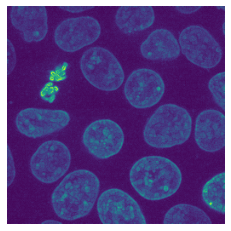

In [6]:
from skimage.data import cells3d

# load example 3D image
cells = cells3d()

centers = cells[:, 1, ...]/np.max(cells[:, 1, ...])
centers_gm = gradient_magnitude(centers)

# create a linear combination of the two images
target_image = 1*centers + 3*centers_gm

# show a slice of the 3D volumes
plt.imshow(target_image[29, ...])
plt.axis('off')

In [7]:
from scipy.linalg import lstsq

A, x, b = combine_MR_channels(target_image, centers, centers_gm, np.arange(target_image.size))

print('Shape of A:', A.shape)
print('Shape of b:', b.shape)
print('Parameters x using Numba implementation:\n', x)
print('Parameters x using SciPy implementation:\n', lstsq(A, b)[0])
print('Sum of differences:\n', np.sum(np.dot(A, x)-b))

Shape of A: (3932160, 3)
Shape of b: (3932160, 1)
Parameters x using Numba implementation:
 [[1.]
 [3.]
 [0.]]
Parameters x using SciPy implementation:
 [[1.]
 [3.]
 [0.]]
Sum of differences:
 -2.4168797102541717e-09


In [8]:
@njit
def LC2_metric(us, mr, mr_gm):
    """
    Computes the LC2 similarity metric for the entire image. 
    :param us: US image
    :param mr: MR image
    :param mr_gm: Gradient magnitude of MR image
    :return: LC2, weight
    """    
    # initialize variables
    LC2 = 0.0
    weight = 0.0
    
    # find all non-zero elements in the ultrasound image
    ids = np.flatnonzero(us)

    # at least two non-zero elements are required for calculating the variance 
    if len(ids) > 1:
        
        # calculate the variance of all non-zero elements in the ultrasound image
        U_var = np.var(us.flatten()[ids])
        
        # check if the variance is non-zero to prevent division by zero errors
        if U_var > 1e-12:
    
            # make sure the arrays are contiguous
            us = np.ascontiguousarray(us)
            mr = np.ascontiguousarray(mr)
            mr_gm = np.ascontiguousarray(mr_gm)
    
            # flatten the images and find the weights for combining the MR channels
            M, c, U = combine_MR_channels(us, mr, mr_gm, np.arange(us.size))
            
            # calculate the LC2
            LC2 = 1 - (np.sum((U-np.dot(M, c))**2) / (len(ids)*U_var))
            weight = np.sqrt(U_var)
    
    return LC2, weight

In [9]:
# check if the LC2 metric is equal to one
LC2, _ = LC2_metric(target_image, centers, centers_gm)
print(f'LC2 similarity metric: {LC2:0.1f}')

LC2 similarity metric: 1.0


In [14]:
@vectorize
def clip_below(value, threshold):
    """
    Clips value if below threshold.
    :value: numeric value
    :threshold: numeric threshold
    :returns: value (after clipping)
    """
    if value < threshold:
        value = threshold
    return value

@njit(parallel=True)
def LC2_similarity_3D_patch(us, mr, mr_gm, patch_size):
    """
    Computes the 3D patch-wise LC2 similarity metric for the entire image. 
    :param us: US image
    :param mr: MR image
    :param mr_gm: Gradient magnitude of MR image
    :patch_size: size of patch
    :return: LC2_similarity, LC2_map, weight_map
    """
    if patch_size%2 == 0 or patch_size < 1:
        raise ValueError('Invalid patch size')
    
    # define patch-related variable
    offset = patch_size//2

    # define image size related parameters
    max_dim1, max_dim2, max_dim3 = us.shape

    # set all intensity values in the US image below zero to zero 
    us = clip_below(us, 0.0) 

    # allocate memory to store results
    LC2_map = np.zeros(us.shape)
    weight_map = np.zeros(us.shape)

    # loop through all pixels
    for dim3 in prange(max_dim3):
        for dim2 in prange(max_dim2):
            for dim1 in range(max_dim1):
                
                # extract patches from us and mr+grad
                us_patch = us[
                    max(0, dim1-offset):min(max_dim1, dim1+offset+1),
                    max(0, dim2-offset):min(max_dim2, dim2+offset+1),
                    max(0, dim3-offset):min(max_dim3, dim3+offset+1)
                ]
                
                mr_patch = mr[
                    max(0, dim1-offset):min(max_dim1, dim1+offset+1),
                    max(0, dim2-offset):min(max_dim2, dim2+offset+1),
                    max(0, dim3-offset):min(max_dim3, dim3+offset+1)
                ]
                    
                mr_gm_patch = mr_gm[
                    max(0, dim1-offset):min(max_dim1, dim1+offset+1),
                    max(0, dim2-offset):min(max_dim2, dim2+offset+1),
                    max(0, dim3-offset):min(max_dim3, dim3+offset+1)
                ]

                LC2_map[dim1, dim2, dim3], weight_map[dim1, dim2, dim3] = LC2_metric(us_patch, mr_patch, mr_gm_patch)
    
    if np.sum(weight_map) == 0:
        return 0, LC2_map, weight_map
    else:
        return np.sum(LC2_map*weight_map) / np.sum(weight_map), LC2_map, weight_map

In [15]:
from time import perf_counter

# check if the patch-wise LC2 metric is equal to 1.0 (Note: only a section of the image is used because of the long computation time)
start = perf_counter()
LC2, _, _ = LC2_similarity_3D_patch(target_image[:, :100, :100], centers[:, :100, :100], centers_gm[:, :100, :100], 19)
end = perf_counter()
print(f'LC2 similarity metric: {LC2:0.1f} ({end-start:0.1f}s)')

LC2 similarity metric: 1.0 (76.2s)
